[参照サイト](https://logics-of-blue.com/python-state-space-models/)

In [2]:
# 基本のライブラリを読み込む
import numpy as np
import pandas as pd
from scipy import stats

# グラフ描画
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline

# グラフを横長にする
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

# 統計モデル
import statsmodels.api as sm

C:\Users\seiya.kumada\AppData\Local\Temp\ipykernel_27692\1364820393.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')


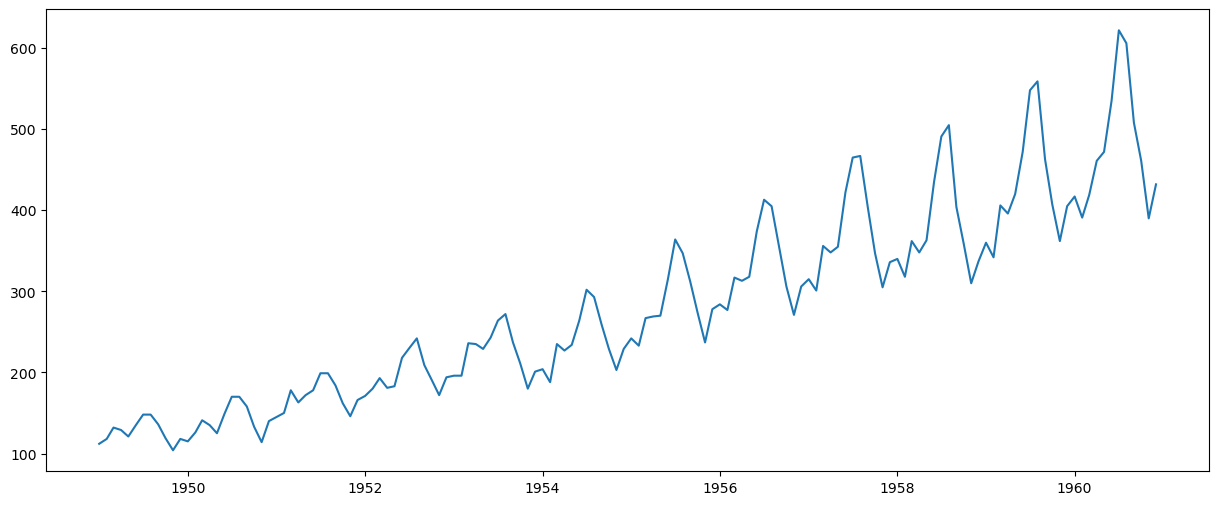

In [4]:
PATH = 'C://data//time_series_data//AirPassengers.csv'
# 日付形式で読み込む
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv(PATH, index_col='Month', date_parser=dateparse, dtype='float')

# 日付形式にする
ts = data['#Passengers'] 
ts.head()

# プロット
plt.plot(ts)

In [5]:
sm.__version__

'0.13.5'

c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                        Unobserved Components Results                         
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                    local level   Log Likelihood                -705.955
Date:                Tue, 13 Jun 2023   AIC                           1415.909
Time:                        13:26:28   BIC                           1421.835
Sample:                    01-01-1949   HQIC                          1418.317
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.312e-07     85.482   1.53e-09      1.000    -167.542     167.542
sigma2.level      1136.4043    176.695      6.431      0.000     790.088    1482.721
Ljung-Box (L1) (Q):         

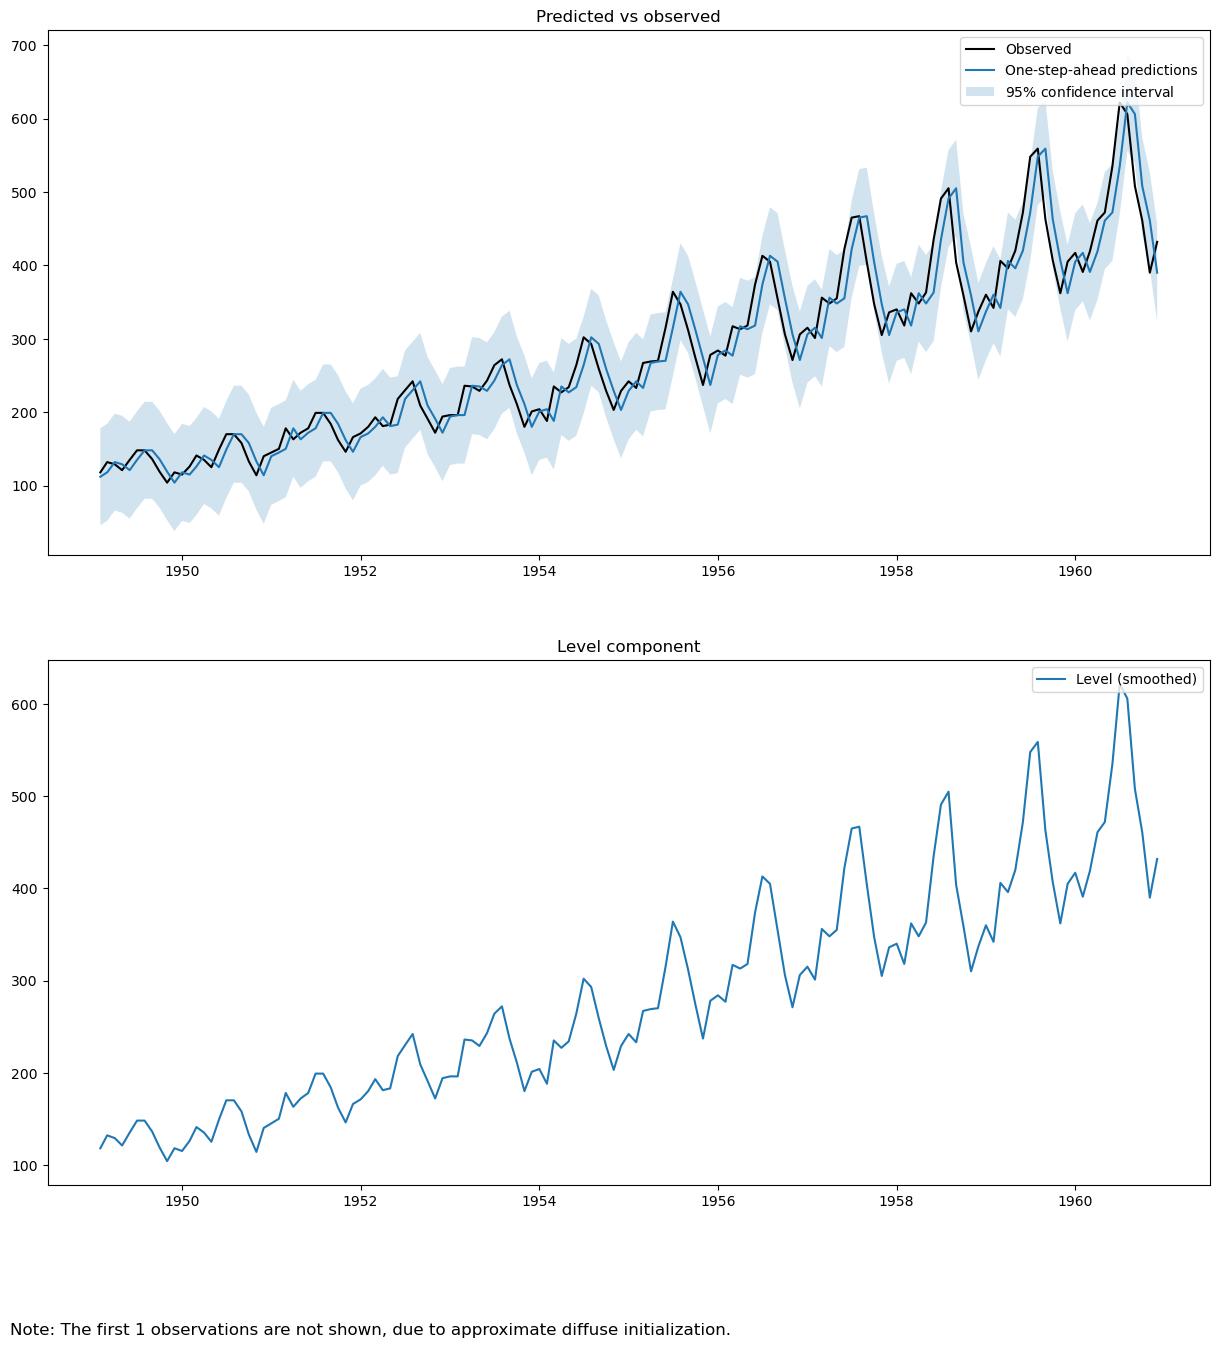

In [7]:
# ローカルレベルモデルを定義する。
# ローカルレベルモデルを採用するので"local level"を指定している。
# ローカルモデル = ランダムウォーク + ノイズ
mod_local_level = sm.tsa.UnobservedComponents(ts, 'local level')

# 最尤法によるパラメタの推定
# 訓練とテストに分けたい。
res_local_level = mod_local_level.fit()

# 推定されたパラメタ一覧
print(res_local_level.summary())

# 推定された状態・トレンドの描画
rcParams['figure.figsize'] = 15, 15
fig = res_local_level.plot_components()

- 1枚目が観測値と予測値の比較。予測値は1か月前の値を出す。
- 2枚目が推定された状態のグラフ。状態とは？こっちのグラフは何ですか？

c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 5.015259
         Iterations: 19
         Function evaluations: 30
         Gradient evaluations: 30
                        Unobserved Components Results                         
Dep. Variable:            #Passengers   No. Observations:                  144
Model:             local linear trend   Log Likelihood                -722.197
Date:                Tue, 13 Jun 2023   AIC                           1450.394
Time:                        13:35:08   BIC                           1459.262
Sample:                    01-01-1949   HQIC                          1453.998
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular    86.590

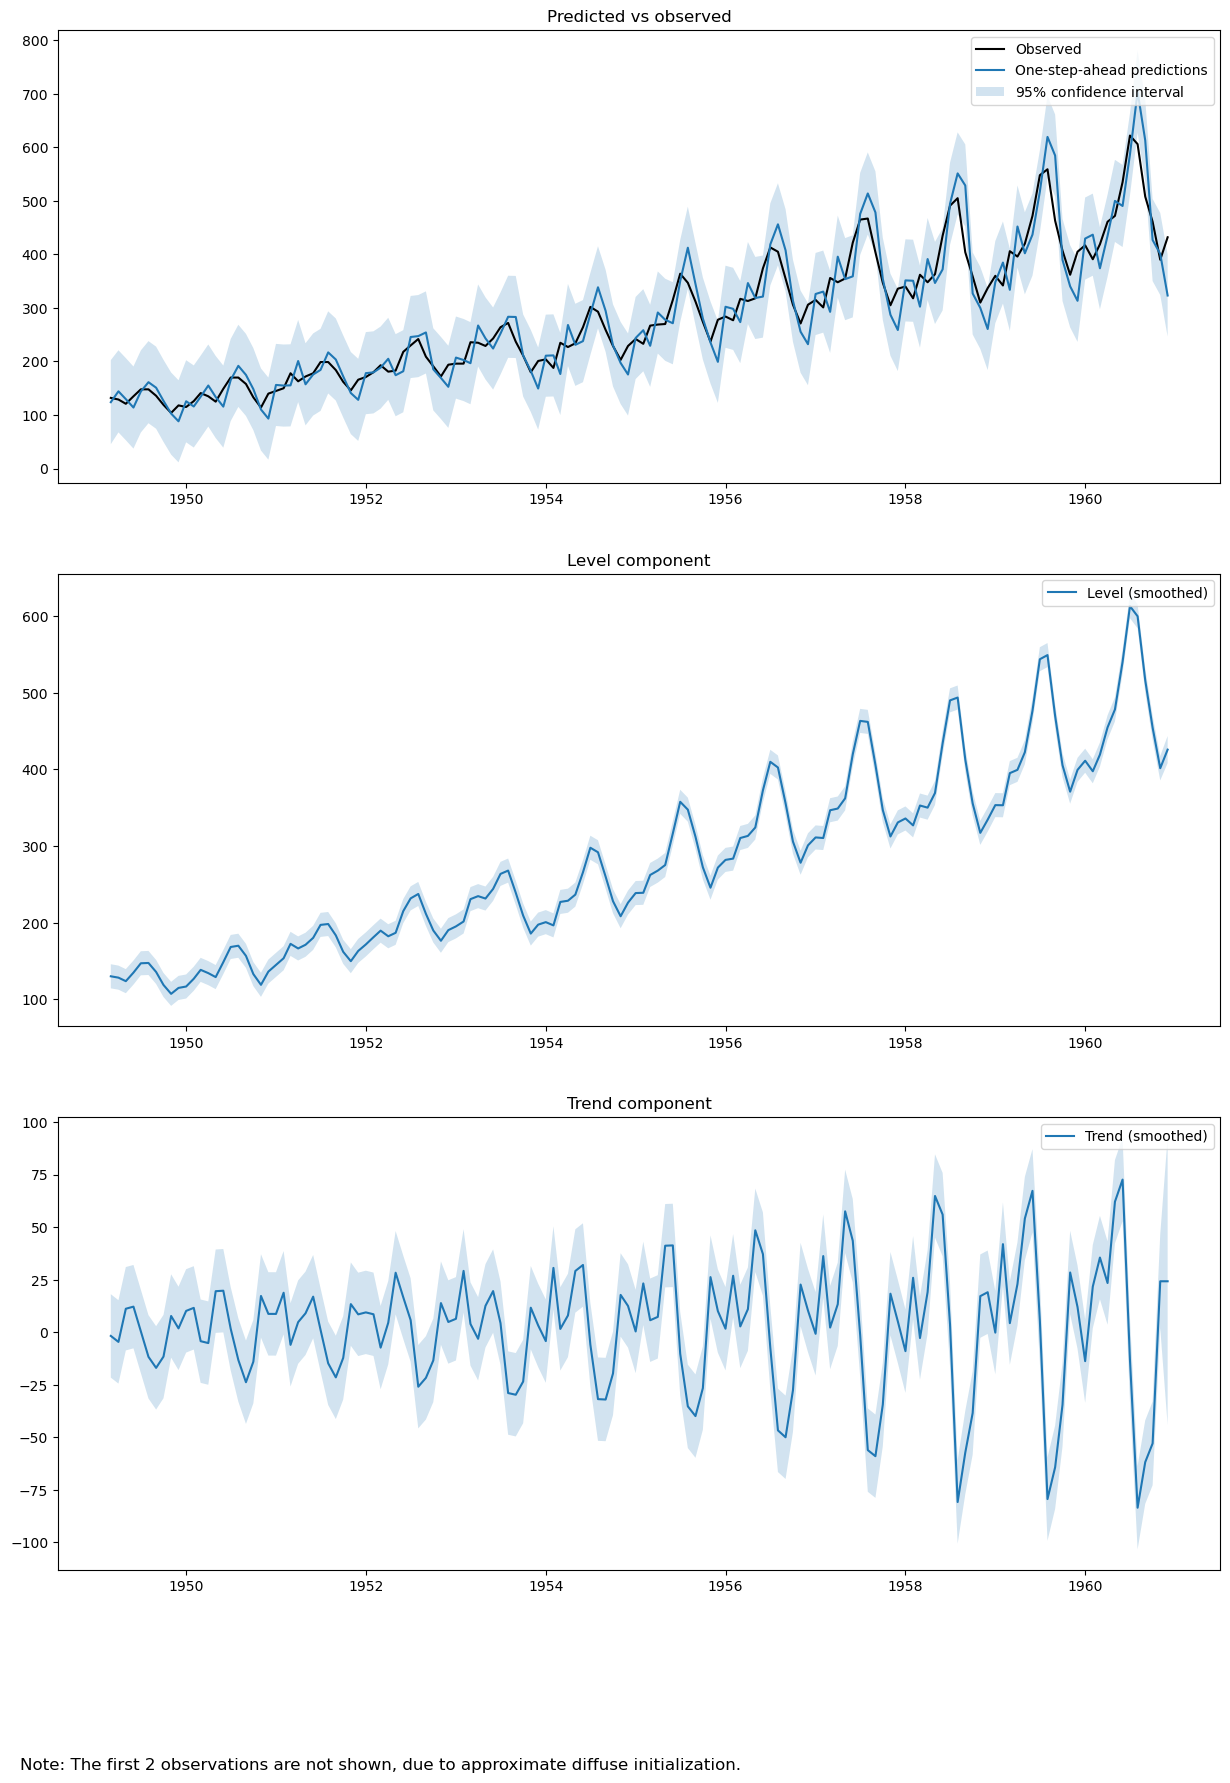

In [8]:
# ローカル線形トレンドモデル
# トレンドを考慮する。
mod_trend = sm.tsa.UnobservedComponents(
    ts,
    'local linear trend'
)

# 最尤法によるパラメタの推定
# ワーニングが出たのでBFGS法で最適化する
res_trend = mod_trend.fit(method='bfgs')

# 推定されたパラメタ一覧
print(res_trend.summary())

# 推定された状態・トレンドの描画
rcParams['figure.figsize'] = 15, 20
fig = res_trend.plot_components()

- 3枚目では、季節由来の周期をトレンドだけで無理矢理表そうとした結果、必要以上に振動している。

c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 3.969241
         Iterations: 148
         Function evaluations: 266
Optimization terminated successfully.
         Current function value: 3.969241
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
                            Unobserved Components Results                            
Dep. Variable:                   #Passengers   No. Observations:                  144
Model:                           local level   Log Likelihood                -571.571
                   + stochastic seasonal(12)   AIC                           1149.142
Date:                       Tue, 13 Jun 2023   BIC                           1157.790
Time:                               13:42:34   HQIC                          1152.656
Sample:                           01-01-1949                                         
                                - 12-01-1960                                         
Cov

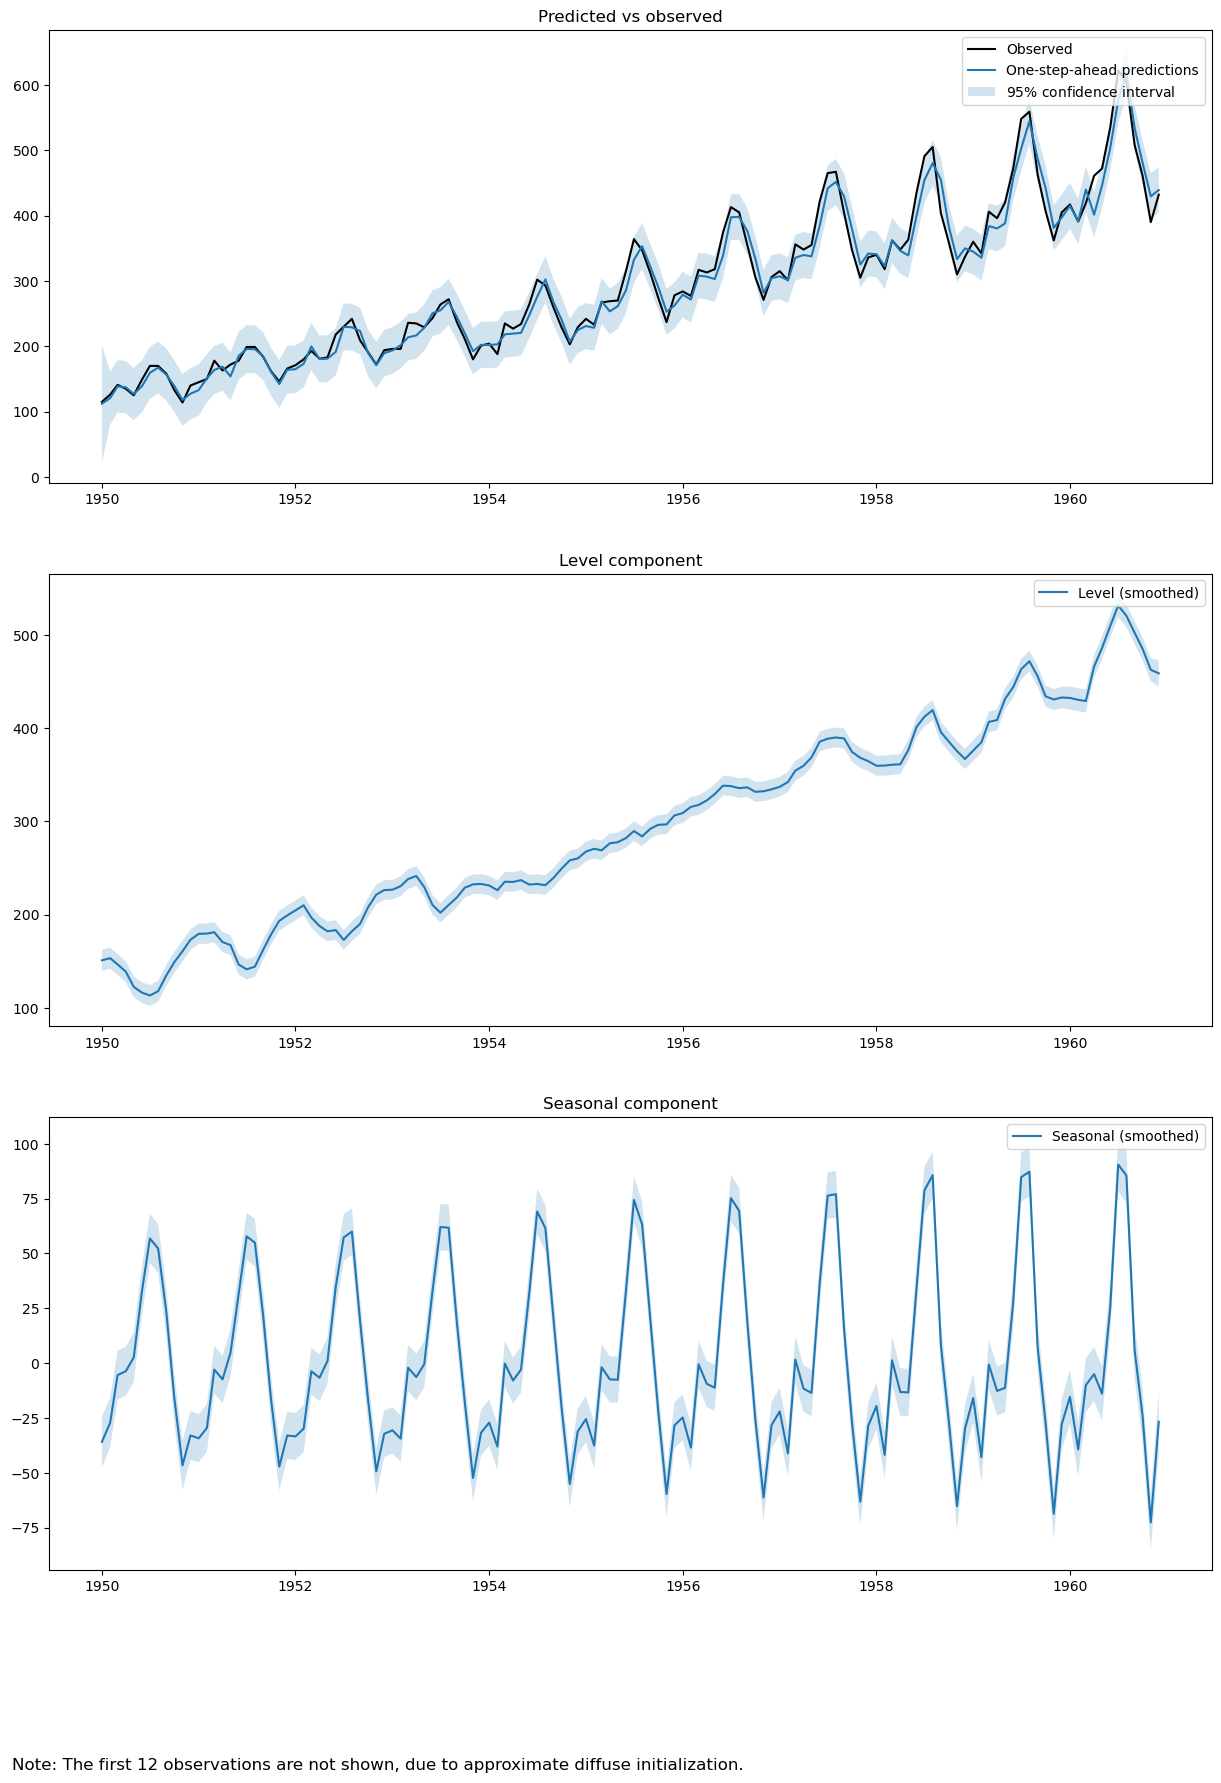

In [9]:
# 季節変動ありのローカルレベルモデル

mod_season_local_level = sm.tsa.UnobservedComponents(
    ts,
    'local level',
    seasonal=12
)

# まずはNelder-Meadでパラメタを推定し、その結果を初期値としてまた最適化する。2回目はBFGSを使用。
res_season_local_level = mod_season_local_level.fit(
    # この引数は重要
    method='bfgs',
    # これも重要（最大繰り返し数） 
    maxiter=500, 
    start_params=mod_season_local_level.fit(method='nm', maxiter=500).params,
)

# 推定されたパラメタ一覧
print(res_season_local_level.summary())

# 推定された状態・トレンド・季節の影響の描画
rcParams['figure.figsize'] = 15, 20
fig = res_season_local_level.plot_components()

- 最適化を二回行う。手間暇かけないとパラメータを推定できない。

c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 3.930912
         Iterations: 495
         Function evaluations: 827
Optimization terminated successfully.
         Current function value: 3.930912
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
                            Unobserved Components Results                            
Dep. Variable:                   #Passengers   No. Observations:                  144
Model:                    local linear trend   Log Likelihood                -566.051
                   + stochastic seasonal(12)   AIC                           1140.103
Date:                       Tue, 13 Jun 2023   BIC                           1151.603
Time:                               13:50:03   HQIC                          1144.776
Sample:                           01-01-1949                                         
                                - 12-01-1960                                         
Cov

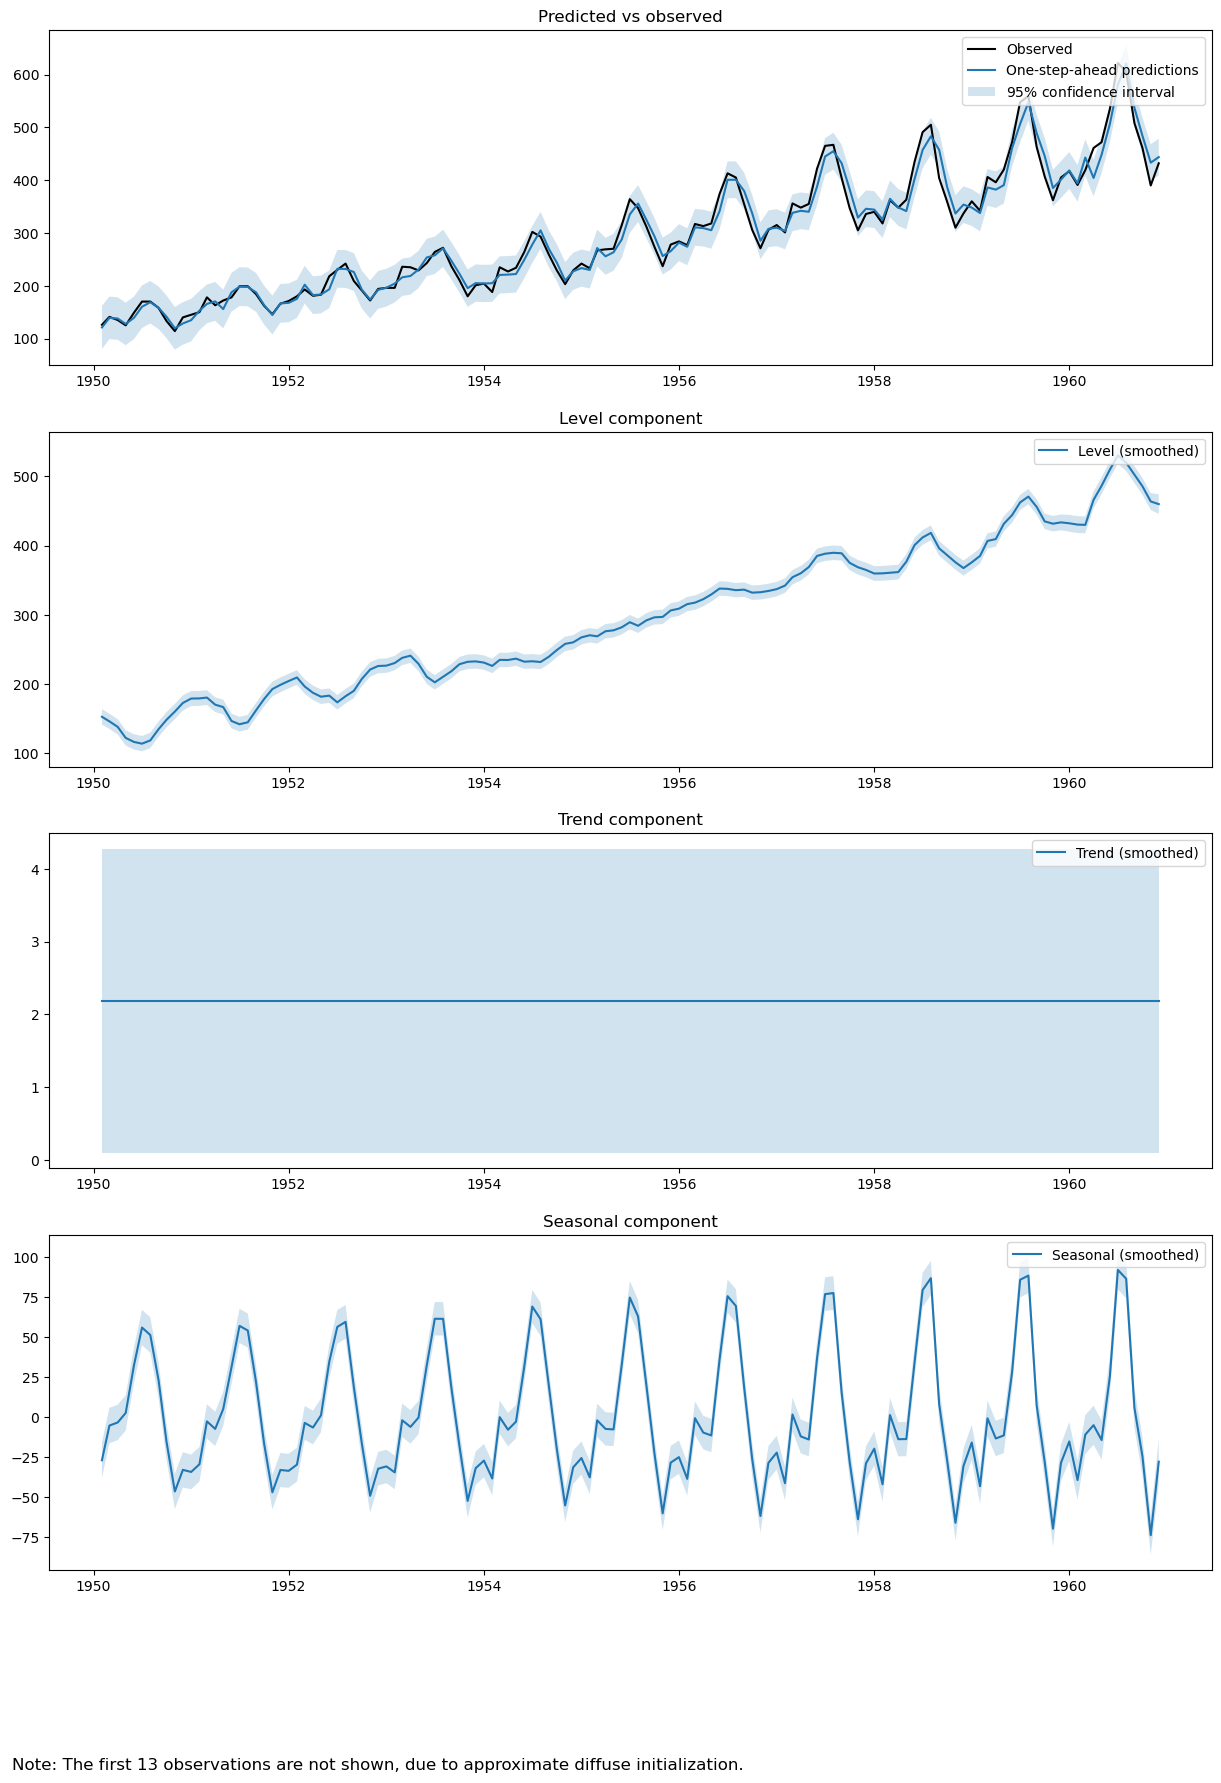

In [10]:
# 季節変動ありのローカル線形トレンドモデル

mod_season_trend = sm.tsa.UnobservedComponents(
    ts,
    'local linear trend',
    seasonal=12
)

# まずはNelder-Meadでパラメタを推定し、その結果を初期値としてまた最適化する。2回目はBFGSを使用。
res_season_trend = mod_season_trend.fit(
    method='bfgs', 
    maxiter=500, 
    start_params=mod_season_trend.fit(method='nm', maxiter=500).params,
)

# 推定されたパラメタ一覧
print(res_season_trend.summary())

# 推定された状態・トレンド・季節の影響の描画
rcParams['figure.figsize'] = 15, 20
fig = res_season_trend.plot_components()

- 3枚目：トレンドが一定なった。つまり、グラフは線形に増加するということ。
- 4枚目：季節成分

パラメータの値を見る。
- irregular: 観測誤差の分散
- level: 状態のシステムノイズ
- trend: トレンドのシステムノイズ
- seasonal: 季節成分のシステムノイズ

c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 3.930912
         Iterations: 115
         Function evaluations: 209
Optimization terminated successfully.
         Current function value: 3.930912
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
                               Unobserved Components Results                                
Dep. Variable:                          #Passengers   No. Observations:                  144
Model:             local linear deterministic trend   Log Likelihood                -566.051
                          + stochastic seasonal(12)   AIC                           1138.103
Date:                              Tue, 13 Jun 2023   BIC                           1146.728
Time:                                      14:03:39   HQIC                          1141.608
Sample:                                  01-01-1949                                         
                                       -

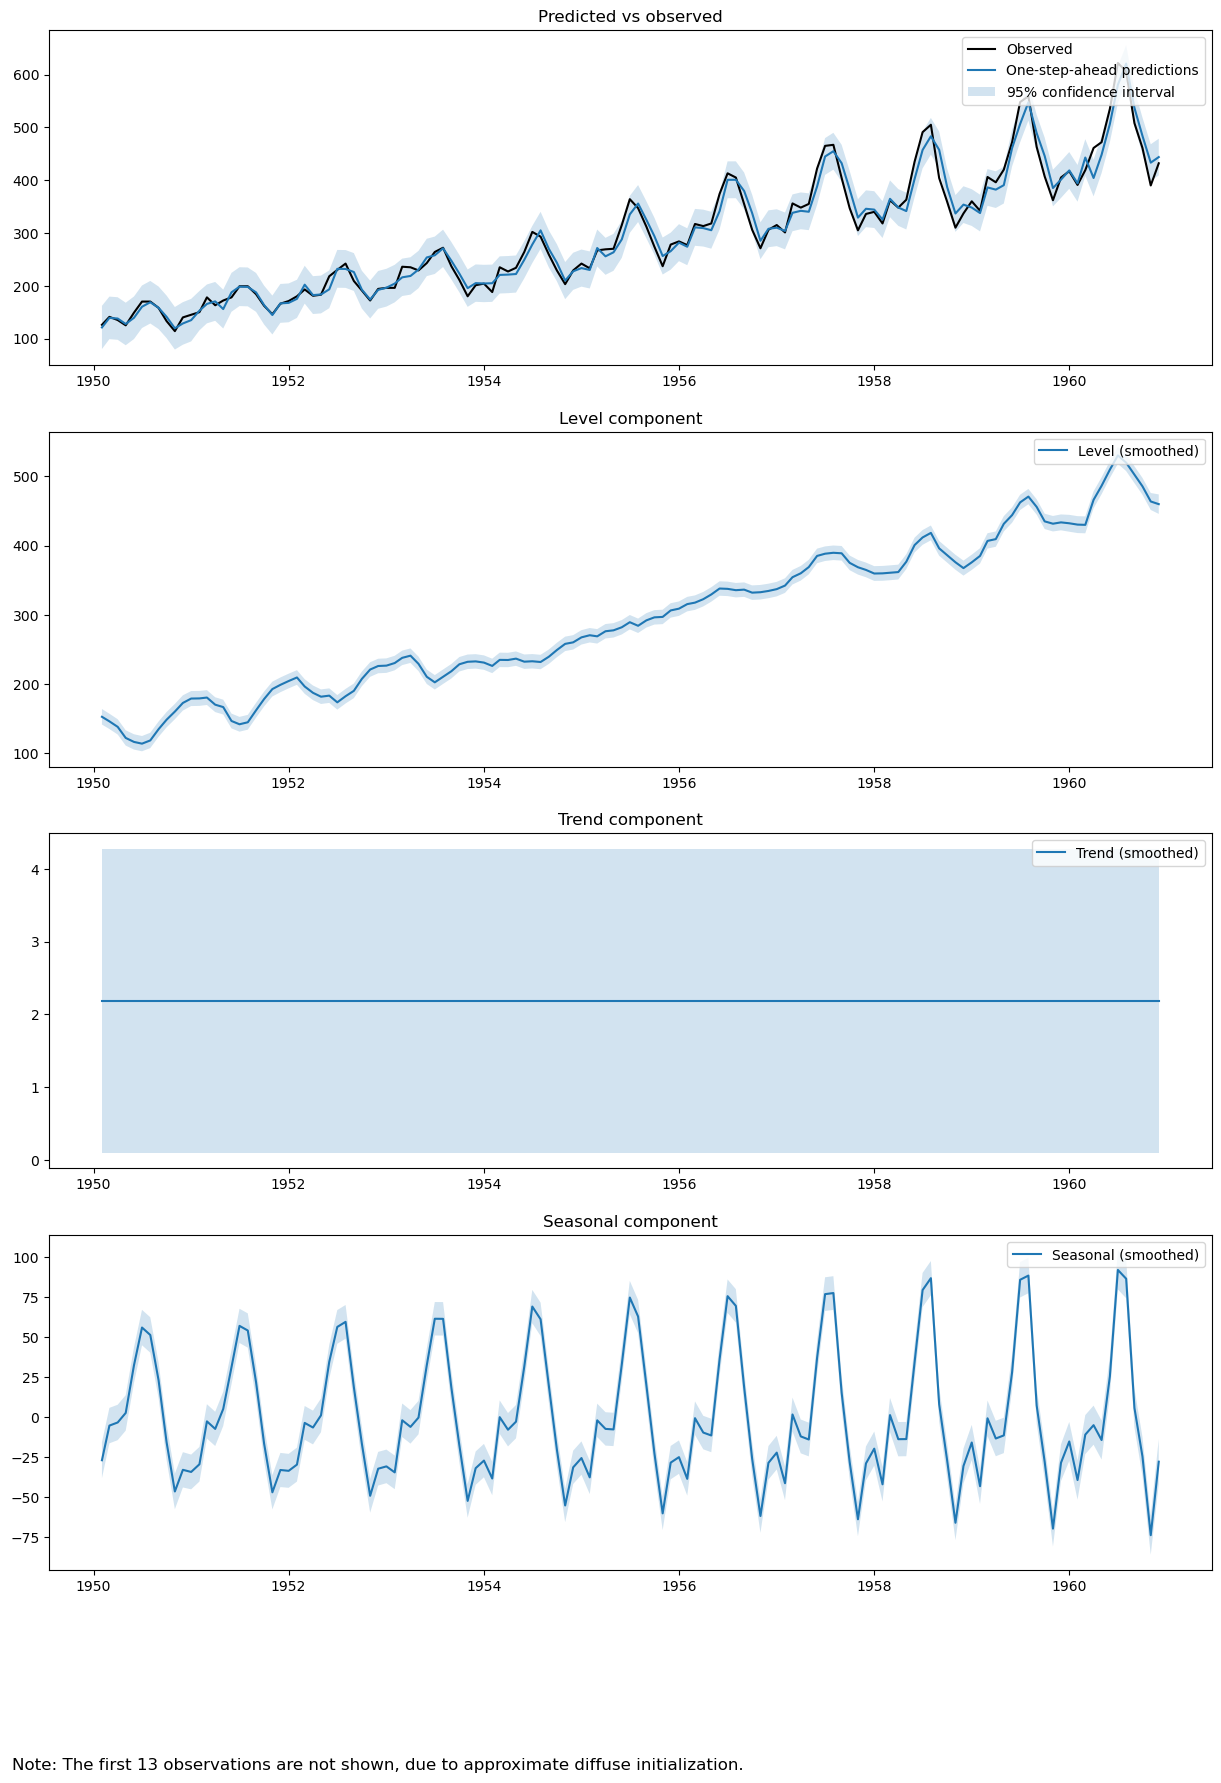

In [11]:
# 詳細は以下の資料を参照してください
# http://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html#statsmodels.tsa.statespace.structural.UnobservedComponents

# 季節変動ありのローカル線形トレンドモデル
# ただし、トレンドの分散は無し

mod_season_trend_d = sm.tsa.UnobservedComponents(
    ts,
    'local linear deterministic trend',
    seasonal=12
)

# まずはNelder-Meadでパラメタを推定し、その結果を初期値としてまた最適化する。2回目はBFGSを使用。
res_season_trend_d = mod_season_trend_d.fit(
    method='bfgs', 
    maxiter=500, 
    start_params=mod_season_trend_d.fit(method='nm', maxiter=500).params,
)

# 推定されたパラメタ一覧
print(res_season_trend_d.summary())

# 推定された状態・トレンド・季節の影響の描画
rcParams['figure.figsize'] = 15, 20
fig = res_season_trend_d.plot_components()

c:\Users\seiya.kumada\Anaconda3\envs\pmdarima\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 3.930912
         Iterations: 66
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 3.930912
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
                            Unobserved Components Results                            
Dep. Variable:                   #Passengers   No. Observations:                  144
Model:                random walk with drift   Log Likelihood                -566.051
                   + stochastic seasonal(12)   AIC                           1136.103
Date:                       Tue, 13 Jun 2023   BIC                           1141.853
Time:                               14:04:25   HQIC                          1138.439
Sample:                           01-01-1949                                         
                                - 12-01-1960                                         
Cova

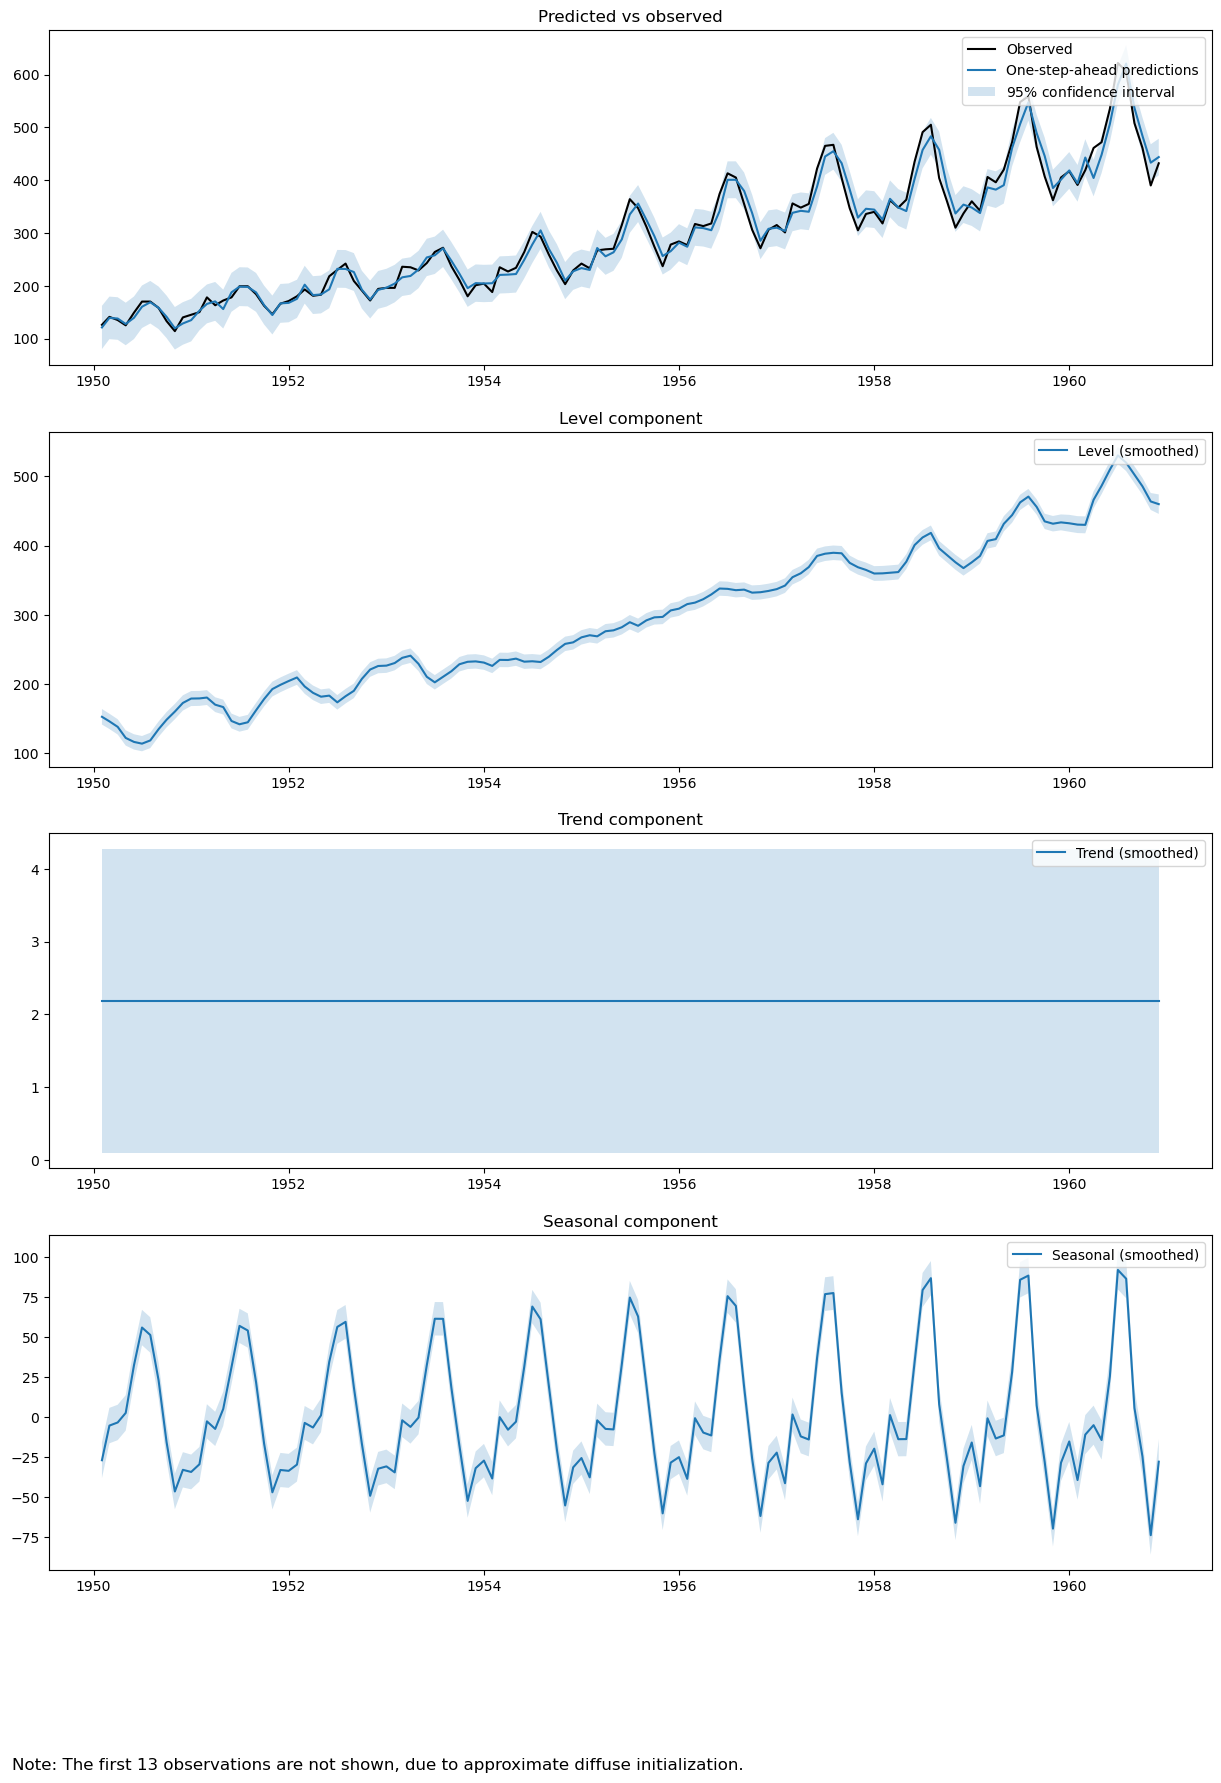

In [12]:
# 詳細は以下の資料を参照してください
# http://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html#statsmodels.tsa.statespace.structural.UnobservedComponents

# 季節変動ありのローカル線形トレンドモデル
# ただし、トレンドと観測誤差の分散は無し

mod_season_rw = sm.tsa.UnobservedComponents(
    ts,
    'random walk with drift',
    seasonal=12
)

# まずはNelder-Meadでパラメタを推定し、その結果を初期値としてまた最適化する。2回目はBFGSを使用。
res_season_rw = mod_season_rw.fit(
    method='bfgs', 
    maxiter=500, 
    start_params=mod_season_rw.fit(method='nm', maxiter=500).params,
)

# 推定されたパラメタ一覧
print(res_season_rw.summary())

# 推定された状態・トレンド・季節の影響の描画
rcParams['figure.figsize'] = 15, 20
fig = res_season_rw.plot_components()

In [14]:
# 今まで計算してきたモデルのAICを格納する
aic_list = pd.DataFrame(index=range(6), columns=["model", "aic"])

aic_list.loc[0]["model"] = "res_local_level"
aic_list.loc[0]["aic"] = res_local_level.aic

aic_list.loc[1]["model"] = "res_trend"
aic_list.loc[1]["aic"] = res_trend.aic

aic_list.loc[2]["model"] = "res_season_local_level"
aic_list.loc[2]["aic"] = res_season_local_level.aic

aic_list.loc[3]["model"] = "res_season_trend"
aic_list.loc[3]["aic"] = res_season_trend.aic

aic_list.loc[4]["model"] = "res_season_trend_d"
aic_list.loc[4]["aic"] = res_season_trend_d.aic

aic_list.loc[5]["model"] = "res_season_rw"
aic_list.loc[5]["aic"] = res_season_rw.aic

# 結果の表示
aic_list

,model,aic
0,res_local_level,1415.909117
1,res_trend,1450.394469
2,res_season_local_level,1149.141543
3,res_season_trend,1140.102616
4,res_season_trend_d,1138.102616
5,res_season_rw,1136.102616


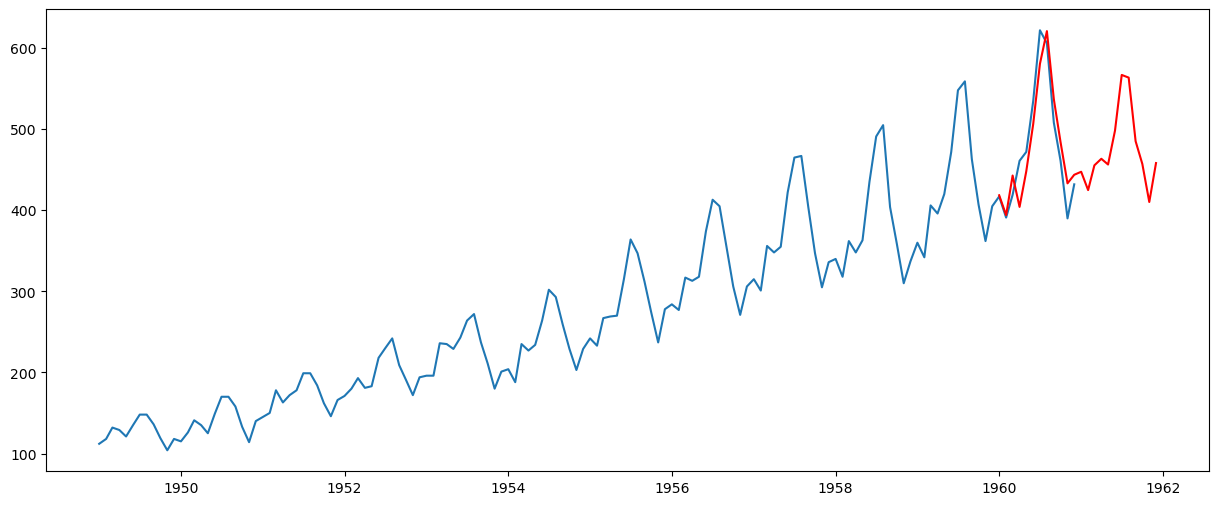

In [15]:
# 予測
pred = res_season_rw.predict('1960-01-01', '1961-12-01')

# 実データと予測結果の図示
rcParams['figure.figsize'] = 15, 6
plt.plot(ts)
plt.plot(pred, "r")